<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.3%20The%20U.S.%20Stock%20Market%20Through%20Time/Section%202.3.2%20Kurtosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns of the S&P 500 
SPX=download('^GSPC','1928-01-03').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('B')
SPX.dropna(inplace=True)
SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,NaN,-0.225230
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,NaN,-0.959368
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,NaN,0.626784
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,NaN,-0.906001
1928-01-10,17.370001,17.370001,17.370001,17.370001,17.370001,NaN,-0.742852
...,...,...,...,...,...,...,...
2023-05-22,4190.779785,4209.220215,4179.680176,4192.629883,4192.629883,3.728520e+09,0.015503
2023-05-23,4176.799805,4185.680176,4142.540039,4145.580078,4145.580078,4.155320e+09,-1.122203
2023-05-24,4132.959961,4132.959961,4103.979980,4115.240234,4115.240234,NaN,-0.731860


In [4]:
# fit a GARCH model using arch package
print("Installing ARCH and fitting model with GED innovations.")
from warnings import filterwarnings ; filterwarnings("ignore",category=RuntimeWarning) # Be quiet, I don't care.
from arch.univariate import ARX, GARCH, GeneralizedError

class GeneralizedError2(GeneralizedError):
    """Version of the GARCH process modified to change the bounds so that Laplace models etc. can be fitted."""
    def bounds(self,*args):
        """Revised bounds."""
        return [(0e0,1e2)]
    
    def constraints(self,*args):
        return np.array([[1], [-1]]), np.array([self.bounds()[0][0],-self.bounds()[0][1]])

from tqdm.notebook import tqdm
results=pd.DataFrame({"year":[],"mu":[],"phi":[],"C":[],"A":[],"B":[],"kappa":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')

for year in tqdm(range(SPX.index[0].year,SPX.index[-1].year)):
    model = ARX(SPX.loc[SPX.index.year==year,"Return"],lags=[1])
    model.volatility = GARCH(1, 0, 1)
    model.distribution = GeneralizedError2()
    fit=model.fit(update_freq=0,disp='off')

    if fit.convergence_flag==0:
        mu,phi,C,A,B,nu=tuple(fit.params)
        results=pd.concat([results,pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[one/nu]}).set_index("year")])

results

Installing ARCH and fitting model with GED innovations.


  0%|          | 0/95 [00:00<?, ?it/s]

,mu,phi,C,A,B,kappa
year,,,,,,
1928,0.213514,0.045742,0.128684,0.102046,0.750398,0.740882
1929,0.216353,-0.053090,0.174713,0.249379,0.724780,0.877995
1930,0.112777,-0.106637,0.126815,0.263290,0.730445,0.597731
1931,-0.326920,-0.132280,0.318651,0.097779,0.852807,0.752661
1932,-0.126065,0.023032,1.451915,0.112960,0.757731,0.628476
...,...,...,...,...,...,...
2018,0.070127,-0.025452,0.033164,0.200793,0.799207,0.855953
2019,0.134190,-0.054531,0.041215,0.217330,0.717376,0.743114
2020,0.251206,-0.217363,0.088864,0.301089,0.698911,0.790282


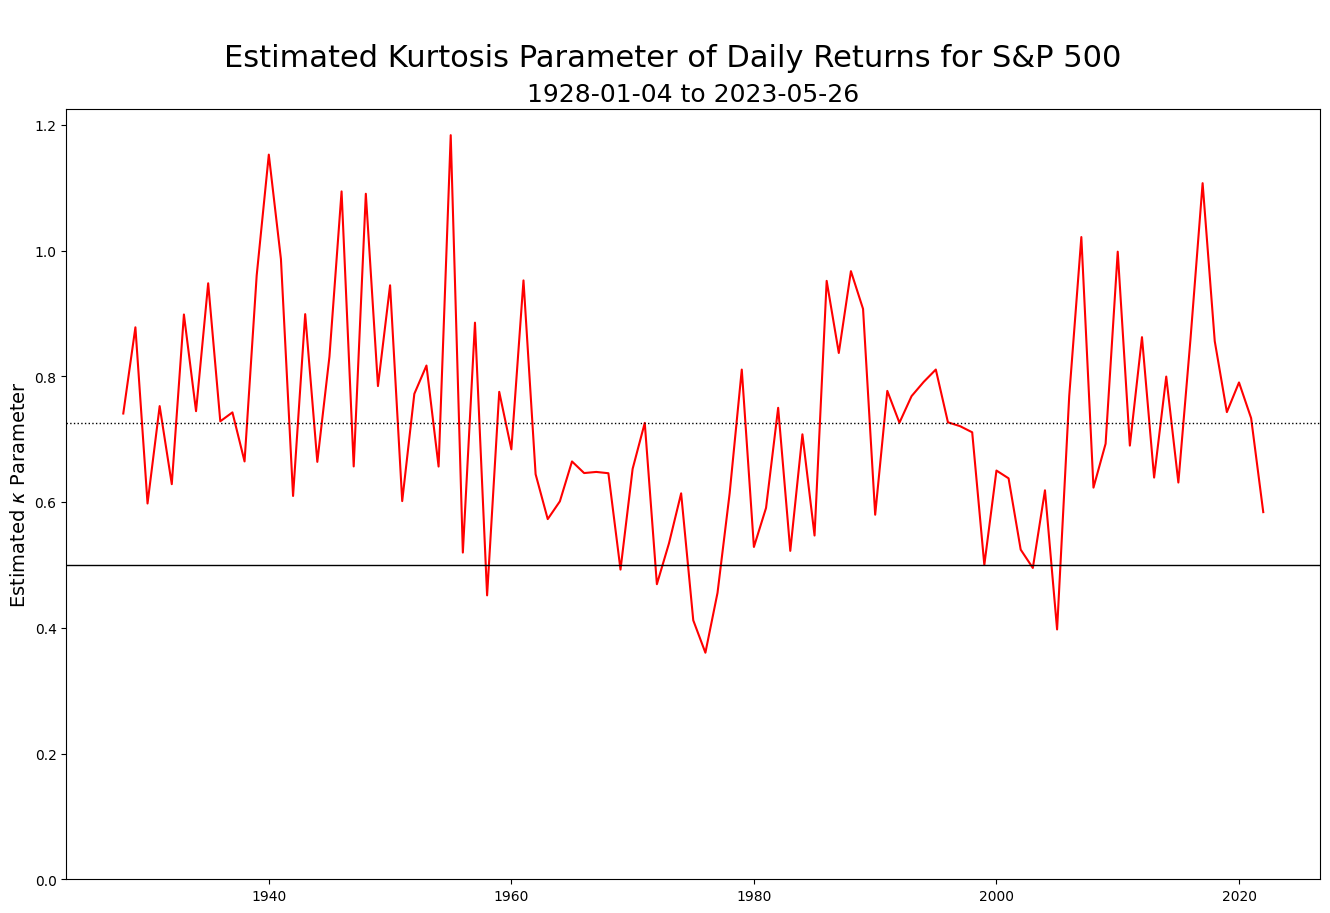

In [6]:
# Figure 2.12
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
figure.suptitle("\nEstimated Kurtosis Parameter of Daily Returns for S&P 500",fontsize=22)
plot.set_title("%s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
plot.plot(results.index,results["kappa"],'-',color="red",label="$\\hat{\\phi}$")
plot.axhline(half,color='black',lw=1)
plot.axhline(results["kappa"].mean(),color='black',lw=1,ls=':')
plot.set_ylabel("Estimated $\\kappa$ Parameter",fontsize=14)
plot.set_ylim(zero,None);